In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_split_dirs(base_dir, split_dir, split_ratio=0.2):
    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        images = os.listdir(cls_path)
        train, val = train_test_split(images, test_size=split_ratio, random_state=42)
        
     
        val_cls_dir = os.path.join(split_dir, 'val', cls)
        os.makedirs(val_cls_dir, exist_ok=True)
        
        for img in val:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_cls_dir, img))


create_split_dirs('/Users/chaitanyakakade/Downloads/colored_images', '/Users/chaitanyakakade/Downloads/colored_images_split', split_ratio=0.2)


In [2]:

train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest"
)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2341 images belonging to 5 classes.
Found 588 images belonging to 5 classes.


In [3]:

from collections import Counter

train_labels = []
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    train_labels += [cls] * len(os.listdir(cls_path))  # Keep cls as a string

counter = Counter(train_labels)
total = sum(counter.values())


class_weights = {cls: total / (len(counter) * count) for cls, count in counter.items()}

print("Class Weights:", class_weights)


Class Weights: {'Mild': 1.9838983050847459, 'Moderate': 0.7327073552425665, 'Proliferate_DR': 2.4904255319148936, 'Severe': 3.8065040650406505, 'No_DR': 0.4053679653679654}


In [14]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='/Users/chaitanyakakade/Downloads/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
__________

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [4]:
class_indices = train_generator.class_indices
print(class_indices) 


{'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


In [5]:
class_weight = {'Mild': 1.9838983050847459, 'Moderate': 0.7327073552425665, 'Proliferate_DR': 2.4904255319148936, 'Severe': 3.8065040650406505, 'No_DR': 0.4053679653679654}


class_weight_mapped = {class_indices[label]: weight for label, weight in class_weight.items()}


In [21]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weight_mapped,
    callbacks=[reduce_lr]
)


Epoch 1/100
74/74 [==============================] - 16s 215ms/step - loss: 1.6004 - accuracy: 0.4071 - val_loss: 1.5360 - val_accuracy: 0.2126 - lr: 8.0000e-06
Epoch 2/100
74/74 [==============================] - 15s 202ms/step - loss: 1.5906 - accuracy: 0.3815 - val_loss: 1.5590 - val_accuracy: 0.1633 - lr: 8.0000e-06
Epoch 3/100
74/74 [==============================] - 15s 200ms/step - loss: 1.5953 - accuracy: 0.3238 - val_loss: 1.5683 - val_accuracy: 0.1548 - lr: 8.0000e-06
Epoch 4/100
74/74 [==============================] - 15s 201ms/step - loss: 1.5991 - accuracy: 0.2747 - val_loss: 1.5781 - val_accuracy: 0.1344 - lr: 8.0000e-06
Epoch 5/100
74/74 [==============================] - 16s 219ms/step - loss: 1.5926 - accuracy: 0.2947 - val_loss: 1.5737 - val_accuracy: 0.1463 - lr: 8.0000e-06
Epoch 6/100
74/74 [==============================] - 15s 200ms/step - loss: 1.5979 - accuracy: 0.2760 - val_loss: 1.5770 - val_accuracy: 0.1361 - lr: 8.0000e-06
Epoch 7/100
74/74 [===============

KeyboardInterrupt: 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [23]:
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()


    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [24]:
input_shape = (224, 224, 3)  
num_classes = 5 

model = create_custom_cnn(input_shape, num_classes)


In [25]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weight_mapped, 
)


Epoch 1/50


2024-09-05 18:00:41.184618: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


74/74 [==============================] - 14s 163ms/step - loss: 1.6461 - accuracy: 0.3729 - val_loss: 1.5772 - val_accuracy: 0.2483
Epoch 2/50
74/74 [==============================] - 14s 192ms/step - loss: 1.4295 - accuracy: 0.5378 - val_loss: 1.0674 - val_accuracy: 0.5153
Epoch 3/50
74/74 [==============================] - 14s 182ms/step - loss: 1.3636 - accuracy: 0.5412 - val_loss: 1.0252 - val_accuracy: 0.6241
Epoch 4/50
74/74 [==============================] - 13s 181ms/step - loss: 1.3798 - accuracy: 0.5070 - val_loss: 0.9404 - val_accuracy: 0.5272
Epoch 5/50
74/74 [==============================] - 14s 185ms/step - loss: 1.3537 - accuracy: 0.5147 - val_loss: 1.2670 - val_accuracy: 0.4677
Epoch 6/50
74/74 [==============================] - 14s 194ms/step - loss: 1.3368 - accuracy: 0.5305 - val_loss: 1.0149 - val_accuracy: 0.6071
Epoch 7/50
74/74 [==============================] - 14s 182ms/step - loss: 1.3257 - accuracy: 0.5412 - val_loss: 0.9784 - val_accuracy: 0.5238
Epoch 8/50

KeyboardInterrupt: 

In [26]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


19/19 [==============================] - 1s 57ms/step - loss: 0.9219 - accuracy: 0.6293
Validation Loss: 0.9219263792037964, Validation Accuracy: 0.6292517185211182


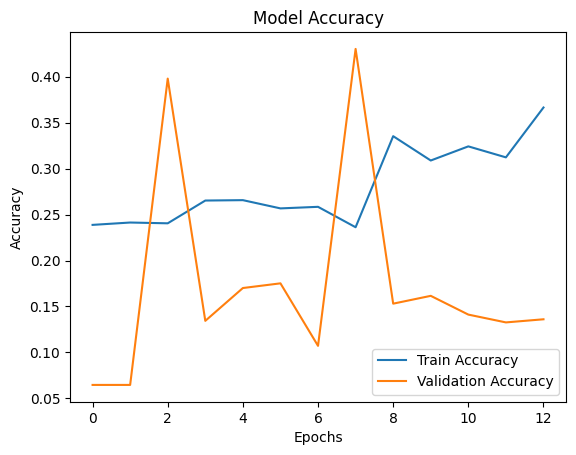

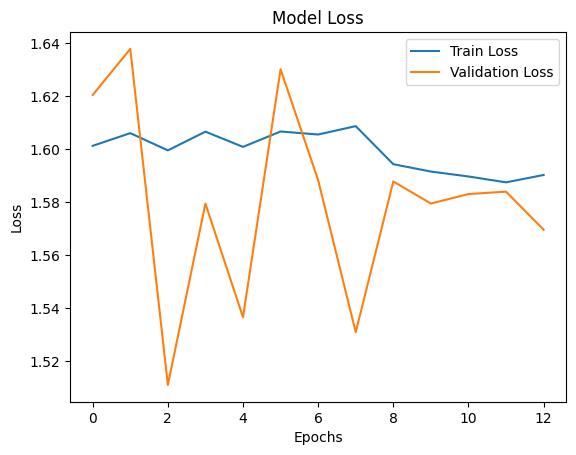

In [27]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [16]:
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau

def create_advanced_cnn(input_shape, num_classes):
    model = Sequential()


    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model1 = create_robust_cnn(input_shape=(224, 224, 3), num_classes=5)


In [17]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [18]:
history = model1.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weight_mapped, 
    
)


Epoch 1/30


2024-09-05 18:18:07.442826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


74/74 [==============================] - 15s 187ms/step - loss: 3.6343 - accuracy: 0.3443 - val_loss: 3.8283 - val_accuracy: 0.1020
Epoch 2/30
74/74 [==============================] - 14s 183ms/step - loss: 2.9726 - accuracy: 0.4079 - val_loss: 3.7199 - val_accuracy: 0.0816
Epoch 3/30
74/74 [==============================] - 14s 183ms/step - loss: 2.5600 - accuracy: 0.4665 - val_loss: 3.0789 - val_accuracy: 0.1020
Epoch 4/30
74/74 [==============================] - 15s 196ms/step - loss: 2.2982 - accuracy: 0.4874 - val_loss: 2.9208 - val_accuracy: 0.0646
Epoch 5/30
74/74 [==============================] - 14s 189ms/step - loss: 2.1015 - accuracy: 0.4951 - val_loss: 2.6106 - val_accuracy: 0.1344
Epoch 6/30
74/74 [==============================] - 14s 186ms/step - loss: 1.9910 - accuracy: 0.5194 - val_loss: 3.2545 - val_accuracy: 0.0476
Epoch 7/30
74/74 [==============================] - 14s 190ms/step - loss: 1.8941 - accuracy: 0.5323 - val_loss: 1.6670 - val_accuracy: 0.4405
Epoch 8/30

In [20]:
pip install transformers



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vit

def create_vit_model(input_shape, num_classes):
   
    vit_base = vit.ViT_B16(
        input_shape=input_shape,
        include_top=False,
        pretrained=True,
        classes=num_classes
    )
    
   
    model = tf.keras.Sequential([
        vit_base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


input_shape = (224, 224, 3) 
num_classes = 5  

model = create_vit_model(input_shape, num_classes)

history = model.fit(
    datagen.flow(train_generator, batch_size=32),
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr_on_plateau]
)


ImportError: cannot import name 'vit' from 'tensorflow.keras.applications' (/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/api/_v2/keras/applications/__init__.py)

In [40]:

!pip install transformers[torch]


zsh:1: no matches found: transformers[torch]


In [11]:
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        assert len(image_paths) == len(labels), "Image paths and labels must have the same length"
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        
        return {'pixel_values': image, 'label': label}



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


def load_image_paths(directory):
   
    return [os.path.join(directory, img) for img in os.listdir(directory) if os.path.isfile(os.path.join(directory, img))]

train_image_paths = '/Users/chaitanyakakade/Downloads/colored_images'
val_image_paths = '/Users/chaitanyakakade/Downloads/colored_images_split'

train_image_paths_list = load_image_paths(train_image_paths)
val_image_paths_list = load_image_paths(val_image_paths)


train_labels = [0] * len(train_image_paths_list)  # Dummy labels
val_labels = [0] * len(val_image_paths_list)  # Dummy labels


train_dataset = CustomDataset(image_paths=train_image_paths_list, labels=train_labels, transform=transform)
val_dataset = CustomDataset(image_paths=val_image_paths_list, labels=val_labels, transform=transform)


model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor 
)


trainer.train()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [18]:
pip install transformers datasets pillow torch torchvision



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install datasets


  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.0 MB/s eta 0:00:00
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.0/389.0 kB 35.3 MB/s eta 0:00:00
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.5 MB/s eta 0:00:00
Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.2
    Uninstalling tqdm-4.66.2:
      Successf

In [19]:
import os
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from torchvision import transforms
from datasets import load_dataset, load_metric
from PIL import Image



train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'

def prepare_dataset(data_dir, split='train'):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
    
    for cls in class_names:
        cls_path = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_path):
            image_paths.append(os.path.join(cls_path, img_name))
            labels.append(class_to_idx[cls])
    
    return image_paths, labels, class_names

def preprocess_function(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image']]
    return feature_extractor(images=images, return_tensors="pt")

train_image_paths, train_labels, class_names = prepare_dataset(train_dir, 'train')
val_image_paths, val_labels, _ = prepare_dataset(val_dir, 'val')


feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(class_names))

train_data = {'image': train_image_paths, 'label': train_labels}
val_data = {'image': val_image_paths, 'label': val_labels}

from datasets import Dataset
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

data_collator = transformers.default_data_collator

training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=feature_extractor,
)


trainer.train()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2341 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

NameError: name 'transformers' is not defined

In [20]:
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments
from torchvision import transforms
from datasets import load_dataset, load_metric
from PIL import Image


train_path = '/Users/chaitanyakakade/Downloads/colored_images/train'
val_path = '/Users/chaitanyakakade/Downloads/colored_images/valid'


def load_images_from_folder(folder_path):
    image_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            image_files.append(os.path.join(root, file))
    return image_files

train_images = load_images_from_folder(train_path)
val_images = load_images_from_folder(val_path)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=5)  # Adjust num_labels to match your dataset


def preprocess_function(examples):
    images = [Image.open(img).convert("RGB") for img in examples['file_paths']]
    return processor(images=images, return_tensors="pt")


train_dataset = {'file_paths': train_images}
val_dataset = {'file_paths': val_images}

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)


data_collator = transformers.DefaultDataCollator()


training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor  
)


trainer.train()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'dict' object has no attribute 'map'

In [25]:
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments, DefaultDataCollator
from datasets import Dataset
from PIL import Image
import os


train_path = '/Users/chaitanyakakade/Downloads/colored_images'
val_path = '/Users/chaitanyakakade/Downloads/colored_images_split'  


def load_images_and_labels(folder_path):
    image_files = []
    labels = []
    label_map = {folder: idx for idx, folder in enumerate(os.listdir(folder_path)) if os.path.isdir(os.path.join(folder_path, folder))}
    for label, label_idx in label_map.items():
        label_path = os.path.join(folder_path, label)
        for file_name in os.listdir(label_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(label_path, file_name))
                labels.append(label_idx)
    return image_files, labels


train_images, train_labels = load_images_and_labels(train_path)
val_images, val_labels = load_images_and_labels(val_path)


train_dataset = Dataset.from_dict({"file_paths": train_images, "labels": train_labels})
val_dataset = Dataset.from_dict({"file_paths": val_images, "labels": val_labels})


processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(set(train_labels)))


def preprocess_function(examples):
    images = [Image.open(img).convert("RGB") for img in examples['file_paths']]
    return processor(images=images, return_tensors="pt")


train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)


data_collator = DefaultDataCollator()


training_args = TrainingArguments(
    output_dir='./results', 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor  
)

trainer.train()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2341 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

Step,Training Loss
500,0.637600


TrainOutput(global_step=879, training_loss=0.524404636422115, metrics={'train_runtime': 535.5385, 'train_samples_per_second': 13.114, 'train_steps_per_second': 1.641, 'total_flos': 5.4424087624630886e+17, 'train_loss': 0.524404636422115, 'epoch': 3.0})

In [16]:
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments, DefaultDataCollator
from datasets import Dataset, load_metric
from PIL import Image
import os
train_path = '/Users/chaitanyakakade/Downloads/colored_images'
val_path = '/Users/chaitanyakakade/Downloads/colored_images_split' 


def load_images_and_labels(folder_path):
    image_files = []
    labels = []
    label_map = {folder: idx for idx, folder in enumerate(os.listdir(folder_path)) if os.path.isdir(os.path.join(folder_path, folder))}
    for label, label_idx in label_map.items():
        label_path = os.path.join(folder_path, label)
        for file_name in os.listdir(label_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(label_path, file_name))
                labels.append(label_idx)
    return image_files, labels


train_images, train_labels = load_images_and_labels(train_path)
val_images, val_labels = load_images_and_labels(val_path)
train_dataset = Dataset.from_dict({"file_paths": train_images, "labels": train_labels})
val_dataset = Dataset.from_dict({"file_paths": val_images, "labels": val_labels})


processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(set(train_labels)))


def preprocess_function(examples):
    images = [Image.open(img).convert("RGB") for img in examples['file_paths']]
    return processor(images=images, return_tensors="pt")


train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)


data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir='./results',  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor  
)


trainer.train()


results = trainer.evaluate()


print(f"Accuracy: {results['eval_accuracy']:.4f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2341 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss
500,0.661600
1000,0.432600
1500,0.276100
2000,0.129900
2500,0.076800


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


KeyError: 'eval_accuracy'

In [18]:
results = trainer.evaluate()


print(f"Accuracy: {results['eval_accuracy']:.4f}")

KeyError: 'eval_accuracy'

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  
        max_out, _ = torch.max(x, dim=1, keepdim=True) 
        attn_map = torch.cat([avg_out, max_out], dim=1)  
        attn_map = self.conv1(attn_map)
        return x * self.sigmoid(attn_map)  


class AttentionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(AttentionCNN, self).__init__()
      
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()  

   
        self.spatial_attn = SpatialAttention()

    
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Pass through the base CNN layers
        features = self.base_model(x)

        # Apply the attention mechanism
        attn_output = self.spatial_attn(features)

        # Global Average Pooling
        attn_output = F.adaptive_avg_pool2d(attn_output, (1, 1))
        attn_output = torch.flatten(attn_output, 1)

        # Final classification layer
        output = self.fc(attn_output)
        return output


model = AttentionCNN(num_classes=5)


train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'


from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [6]:

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        validate(model, val_loader)

# Validation
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')


train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 2]

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  #
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        validate(model, val_loader)

# Validation
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

# Start training
train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10)


KeyboardInterrupt: 

In [12]:
import torchvision.models as models
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, c, _, _ = x.size()
        se = self.global_avg_pool(x).view(batch_size, c)
        se = self.fc1(se)
        se = nn.ReLU()(se)
        se = self.fc2(se)
        se = self.sigmoid(se).view(batch_size, c, 1, 1)
        return x * se

class SEResNet18(nn.Module):
    def __init__(self, num_classes):
        super(SEResNet18, self).__init__()
   
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Identity()  
        
      
        self.se_block1 = SEBlock(in_channels=64)  
        self.se_block2 = SEBlock(in_channels=128)
        self.se_block3 = SEBlock(in_channels=256)
        self.se_block4 = SEBlock(in_channels=512)

        
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Pass through ResNet layers
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.se_block1(x)
        x = self.resnet18.layer2(x)
        x = self.se_block2(x)
        x = self.resnet18.layer3(x)
        x = self.se_block3(x)
        x = self.resnet18.layer4(x)
        x = self.se_block4(x)

        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = SEResNet18(num_classes=len(train_dataset.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        validate(model, val_loader)

def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10)


KeyboardInterrupt: 

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Reshape, Multiply, Conv2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class SEBlock(Layer):
    def __init__(self, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(self.filters // self.reduction, activation='relu', use_bias=False)
        self.fc2 = Dense(self.filters, activation='sigmoid', use_bias=False)

    def call(self, inputs):
        x = self.pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = Reshape((1, 1, self.filters))(x)
        return Multiply()([inputs, x])


In [22]:
def create_se_resnet50(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = SEBlock(reduction=16)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    return model


In [23]:
def prepare_data(train_dir, val_dir, batch_size=32, img_size=(224, 224)):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20, 
        width_shift_range=0.3, 
        height_shift_range=0.3,  
        shear_range=0.3, 
        zoom_range=0.3,  
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator


In [24]:
input_shape = (224, 224, 3)
num_classes = 5  

model = create_se_resnet50(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)



val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/20
74/74 [==============================] - 48s 476ms/step - loss: 8.9570 - accuracy: 0.4331 - val_loss: 1459339.1250 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 2/20
74/74 [==============================] - 32s 424ms/step - loss: 3.9795 - accuracy: 0.4182 - val_loss: 882.7333 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 3/20
74/74 [==============================] - 33s 435ms/step - loss: 3.2784 - accuracy: 0.4015 - val_loss: 8760.9600 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 4/20
74/74 [==============================] - 31s 423ms/step - loss: 3.0725 - accuracy: 0.4097 - val_loss: 1.4318 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 5/20
74/74 [==============================] - 32s 434ms/step - loss: 1.7123 - accuracy: 0.4861 - val_loss: 7623.3486 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 6/20
74/74 [==============================] - 32s 429ms/step - loss: 1.8462 - accuracy: 0.4524 - val_loss: 197.5253 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 7/20
74/74 [==============================

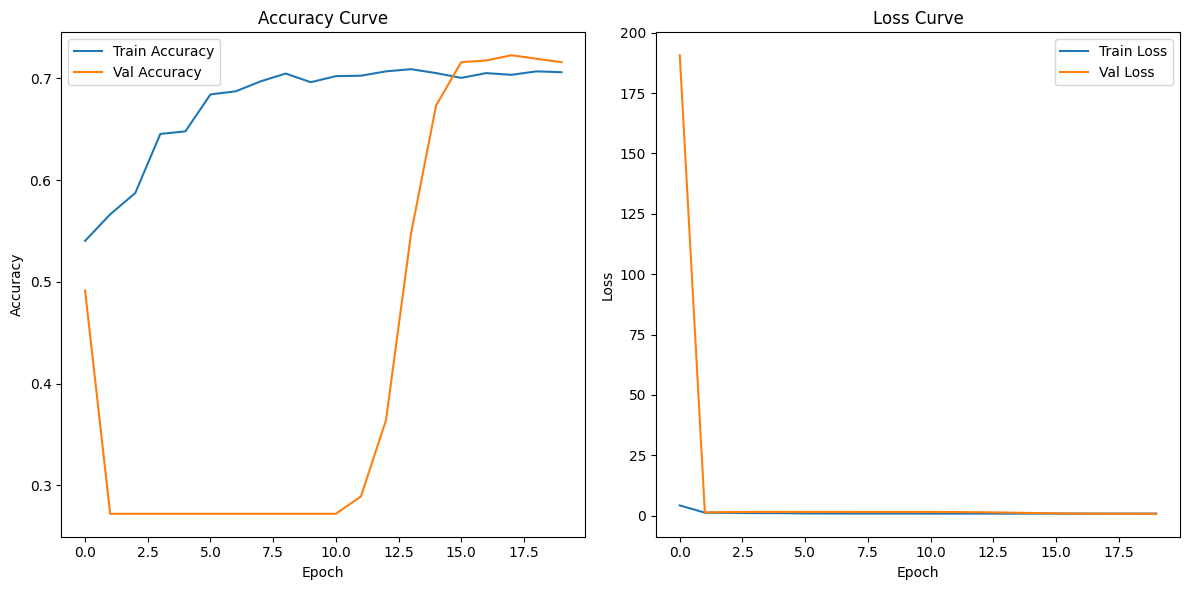

In [22]:
import matplotlib.pyplot as plt

# Assuming `history` is the History object returned from `model.fit()`

# Plot accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf


val_generator.reset()
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(predictions, axis=1)


y_true = val_generator.classes


conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()


def calculate_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    return sensitivity, specificity, precision, recall, f1_score

sensitivity, specificity, precision, recall, f1_score = calculate_metrics(conf_matrix)

print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


19/19 [==============================] - 3s 131ms/step


ValueError: too many values to unpack (expected 4)

19/19 [==============================] - 2s 117ms/step
Confusion Matrix:
[[  0  26  34   0   0]
 [  0  70  90   0   0]
 [  0 134 155   0   0]
 [  0  25  23   0   0]
 [  0  14  17   0   0]]
Classification Report:
                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        60
      Moderate       0.26      0.44      0.33       160
         No_DR       0.49      0.54      0.51       289
Proliferate_DR       0.00      0.00      0.00        48
        Severe       0.00      0.00      0.00        31

      accuracy                           0.38       588
     macro avg       0.15      0.19      0.17       588
  weighted avg       0.31      0.38      0.34       588


Class 0 Metrics:
Sensitivity: 0.00
Specificity: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1 Metrics:
Sensitivity: 0.44
Specificity: 0.54
Precision: 0.26
Recall: 0.44
F1 Score: 0.33

Class 2 Metrics:
Sensitivity: 0.54
Specificity: 0.45
Precision: 0.49
Recall: 0.54
F1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

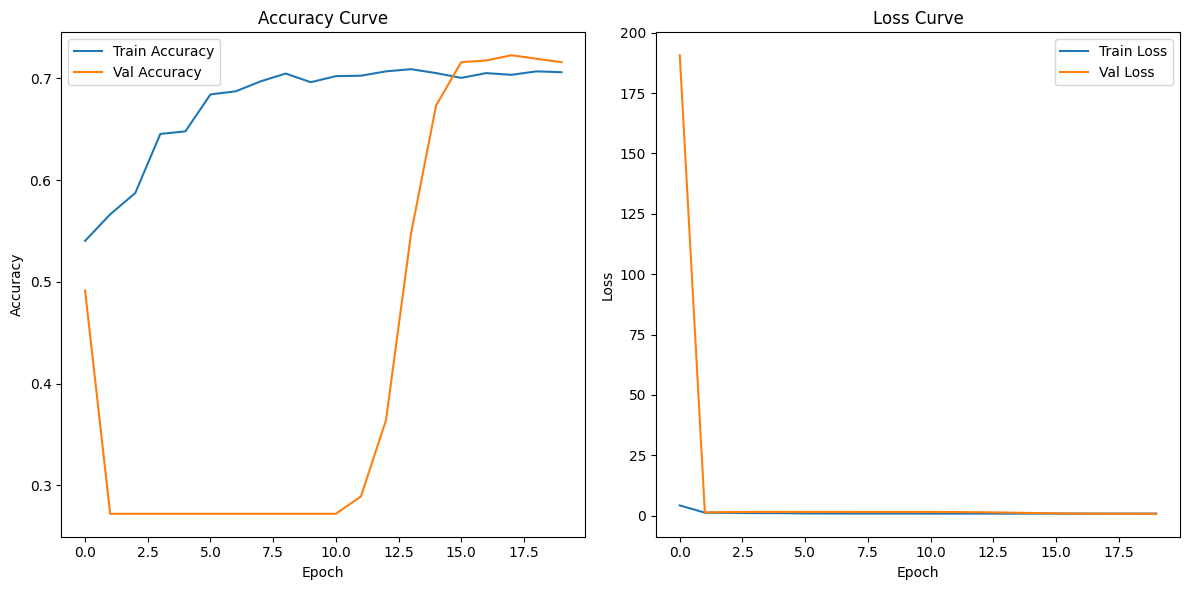

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


val_generator.reset()
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(predictions, axis=1)


y_true = val_generator.classes


conf_matrix = confusion_matrix(y_true, y_pred)


print("Confusion Matrix:")
print(conf_matrix)


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


def calculate_class_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]
    metrics = {}
    
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fn = conf_matrix[i, :].sum() - tp
        fp = conf_matrix[:, i].sum() - tp
        tn = conf_matrix.sum() - (tp + fn + fp)
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = sensitivity
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[f'Class {i}'] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        }
    
    return metrics


class_metrics = calculate_class_metrics(conf_matrix)
for cls, metrics in class_metrics.items():
    print(f"\n{cls} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Conv2D

class SEBlock(Layer):
    def __init__(self, reduction=16):
        super(SEBlock, self).__init__()
        self.reduction = reduction
        
    
    def build(self, input_shape):
        self.global_avg_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(input_shape[-1] // self.reduction, activation='relu', use_bias=False)
        self.fc2 = Dense(input_shape[-1], activation='sigmoid', use_bias=False)
    
    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.reshape(x, (-1, 1, 1, x.shape[1]))  # Reshape to match input dimensions
        return Multiply()([inputs, x])


In [5]:
def create_custom_cnn_with_attention(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    

    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    

    x = SEBlock(reduction=32)(x)
    

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Conv2D, BatchNormalization, MaxPooling2D, Dropout

input_shape = (224, 224, 3)
num_classes = 5
model = create_custom_cnn_with_attention(input_shape, num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data preparation
def prepare_data(train_dir, val_dir, batch_size=32, img_size=(224, 224)):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return train_generator, val_generator

train_dir = '/Users/chaitanyakakade/Downloads/colored_images'
val_dir = '/Users/chaitanyakakade/Downloads/colored_images_split'
train_generator, val_generator = prepare_data(train_dir, val_dir)


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


val_generator.reset()
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes


conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


Found 2341 images belonging to 5 classes.
Found 588 images belonging to 5 classes.
Epoch 1/20


2024-09-08 11:30:51.450924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


61/74 [=======================>......] - ETA: 9s - loss: 4.0130 - accuracy: 0.5595 

KeyboardInterrupt: 